# 仿真 vs 实验：Segment 1（θ0≈49.9°）对比
本 notebook 用同一套 3-DOF ODE 前向仿真框架，在**相同初始条件**下生成仿真曲线，并与实验分段（由 `dqcalc.ipynb` 保存的 Segment CSV）进行对比。

## 这种对比方法是否符合逻辑？
总体上**有意义且符合逻辑**，前提是你辨识出的参数（阻尼、缆绳刚度等）确实对应同一套物理假设与相同的状态定义（θ 的正方向/零点、单位、是否做 lab→phys 转换）。
- 你在实验数据上做参数辨识 → 再用这些参数做前向仿真 → 与同初始条件的实验段对比，这是典型的“模型复现/拟合”流程。
- 但要注意：如果参数就是用同一段数据辨识出来的，这属于 **in-sample**，只能说明“模型能拟合这段数据”；更强的验证需要用其它段（Segment 2/Segment 3）做 **out-of-sample**。

## 本 notebook 做什么
1. 先把 `sim_flip/data/Segment_*.csv` 三个文件画出来，检查保存是否正确。
2. 默认选择 Segment 1（目标约 49.9°）作为实验数据集接入现有仿真对比流程。
3. 按实验初始条件运行仿真：$u_0=w_0=q_0=0$，$\theta_0\approx 49.9^\circ$（稳态参考为 90°）。
4. 绘制论文风格对比图：$\theta(t)$（必要时加 $q(t)$）。


In [16]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# 可选：用于自动截取 seg0（找峰值）
try:
    from scipy.signal import find_peaks  # type: ignore
except Exception:  # noqa: BLE001
    find_peaks = None

# --- 使本地包可导入（从 sim_flip/scripts 运行 notebook）---
# ?????????????????????? sim_flip/ ? repo ???
_CWD = Path.cwd().resolve()
REPO_ROOT = None
for p in [_CWD, *_CWD.parents]:
    if (p / 'sim_flip').is_dir():
        REPO_ROOT = p
        break
if REPO_ROOT is None:
    raise FileNotFoundError(f'??? cwd ?? repo ???????? sim_flip/??cwd={_CWD}')
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# 开发时可能会修改 sim_flip/src 代码；这里强制 reload，避免拿到旧版本
import importlib
import sim_flip.src.dynamics as dynamics  # noqa: E402

importlib.reload(dynamics)
simulate = dynamics.simulate


In [17]:
# --- 论文风格绘图参数（可在此统一调整）---
mpl.rcParams.update({
    "figure.dpi": 130,
    "savefig.dpi": 300,
    "figure.figsize": (7.2, 4.2),
    "font.size": 11,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "-",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 2.0,
})

# Okabe-Ito（色盲友好）配色（与 dqcalc.ipynb 一致风格）
PAL = {
    "blue": "#0072B2",
    "vermillion": "#D55E00",
    "green": "#009E73",
    "gray": "#7f7f7f",
}

def _finalize_ax(ax: plt.Axes, *, title: str | None = None) -> None:
    if title:
        ax.set_title(title)
    ax.grid(True, which="major", alpha=mpl.rcParams["grid.alpha"])
    ax.margins(x=0)

def first_crossing_time(t: np.ndarray, y: np.ndarray, threshold: float) -> float:
    """线性插值：第一次向上越过阈值的时间。"""
    above = y >= threshold
    idx = np.where(above)[0]
    if len(idx) == 0:
        return float("nan")
    i = int(idx[0])
    if i == 0:
        return float(t[0])
    t0, t1 = float(t[i - 1]), float(t[i])
    y0, y1 = float(y[i - 1]), float(y[i])
    if y1 == y0:
        return t1
    frac = (threshold - y0) / (y1 - y0)
    return t0 + frac * (t1 - t0)


## Step 0：检查 dqcalc 导出的 3 个分段 CSV

下面会自动在 `sim_flip/data/` 中寻找 `Segment_1/2/3_*.csv`，并把三段数据画出来。
如果你重新运行了 `dqcalc.ipynb` 导出新文件，只要文件名仍然以 `Segment_1_Target_49_9_` 等开头，这里会自动选择**最新修改时间**的那一份。


[Segment 1 (~49.9deg)] file=Segment_1_Target_49_9_start_32.25s_theta_49.88deg_end_75s.csv | samples=42753 | duration=42.75s | theta0=49.88deg
[Segment 2 (~31.0deg)] file=Segment_2_Target_31_0_start_95.30s_theta_30.87deg_end_130s.csv | samples=34705 | duration=34.70s | theta0=30.87deg
[Segment 3 (~2.5deg)] file=Segment_3_Target_2_5_start_150.79s_theta_2.05deg_end_190s.csv | samples=39210 | duration=39.21s | theta0=2.05deg
Selected dataset -> C:\AD_v2_stage1_analysis\sim_flip\data\Segment_1_Target_49_9_start_32.25s_theta_49.88deg_end_75s.csv


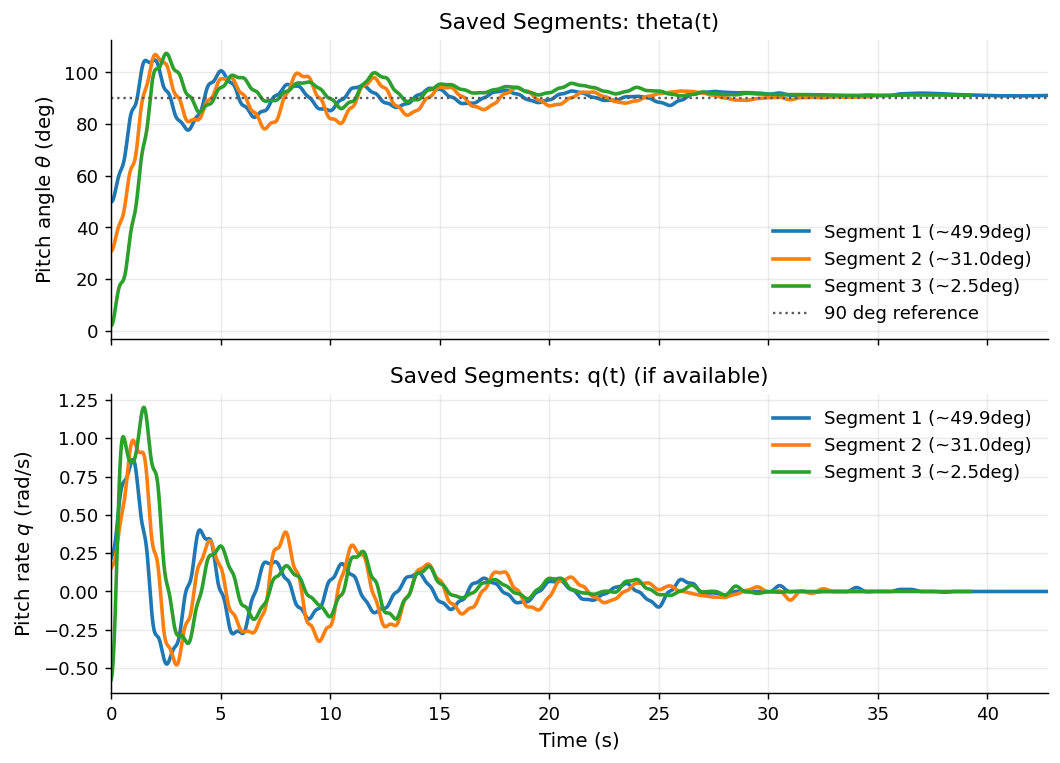

In [18]:
# --- Step 0: Plot saved Segment CSVs (sanity check) ---

from pathlib import Path

SEGMENT_CSV_DIR = (REPO_ROOT / 'sim_flip' / 'data').resolve()
SEGMENT_PATTERNS = {
    'Segment 1 (~49.9deg)': 'Segment_1_Target_49_9_*.csv',
    'Segment 2 (~31.0deg)': 'Segment_2_Target_31_0_*.csv',
    'Segment 3 (~2.5deg)': 'Segment_3_Target_2_5_*.csv',
}

def _pick_latest_by_mtime(dirpath: Path, pattern: str) -> Path | None:
    matches = sorted(dirpath.glob(pattern), key=lambda p: p.stat().st_mtime, reverse=True)
    return matches[0] if matches else None

segment_paths = {k: _pick_latest_by_mtime(SEGMENT_CSV_DIR, pat) for k, pat in SEGMENT_PATTERNS.items()}

missing = [k for k, p in segment_paths.items() if p is None]
if missing:
    print('Warning: missing segment CSVs (run dqcalc.ipynb to export):', missing)

fig, axes = plt.subplots(2, 1, figsize=(8.2, 6.0), sharex=True)
ax_th, ax_q = axes

for name, path in segment_paths.items():
    if path is None:
        continue

    df = pd.read_csv(path)

    if 'Time_rel_s' in df.columns:
        t = df['Time_rel_s'].to_numpy(dtype=float)
    elif 'Time_s' in df.columns:
        t = df['Time_s'].to_numpy(dtype=float)
        t = t - float(t[0])
    else:
        raise ValueError(f'{path.name} missing Time_rel_s/Time_s; columns={df.columns.tolist()}')

    if 'Theta_filt_deg' in df.columns:
        theta_deg = df['Theta_filt_deg'].to_numpy(dtype=float)
    elif 'Theta_filt_rad' in df.columns:
        theta_deg = np.degrees(df['Theta_filt_rad'].to_numpy(dtype=float))
    else:
        raise ValueError(f'{path.name} missing Theta_filt_deg/Theta_filt_rad; columns={df.columns.tolist()}')

    q_rad_s = None
    if 'q_filt_rad' in df.columns:
        q_rad_s = df['q_filt_rad'].to_numpy(dtype=float)
    elif 'q_rad_s' in df.columns:
        q_rad_s = df['q_rad_s'].to_numpy(dtype=float)

    ax_th.plot(t, theta_deg, label=name)
    if q_rad_s is not None:
        ax_q.plot(t, q_rad_s, label=name)

    print(f'[{name}] file={path.name} | samples={len(t)} | duration={float(t[-1]):.2f}s | theta0={float(theta_deg[0]):.2f}deg')

ax_th.axhline(90.0, color='0.35', linestyle=':', linewidth=1.3, label='90 deg reference')
ax_th.set_ylabel(r'Pitch angle $\theta$ (deg)')
_finalize_ax(ax_th, title='Saved Segments: theta(t)')
ax_th.legend(frameon=False, loc='best')

ax_q.set_xlabel('Time (s)')
ax_q.set_ylabel(r'Pitch rate $q$ (rad/s)')
_finalize_ax(ax_q, title='Saved Segments: q(t) (if available)')
ax_q.legend(frameon=False, loc='best')

fig.tight_layout()

# Default dataset selection for the rest of this notebook
DEFAULT_SEGMENT_KEY = 'Segment 1 (~49.9deg)'
SEGMENT_CSV_PATH = str(segment_paths[DEFAULT_SEGMENT_KEY]) if segment_paths.get(DEFAULT_SEGMENT_KEY) is not None else None
print('Selected dataset ->', SEGMENT_CSV_PATH)


In [19]:
# --- Load experimental data (prefer Segment CSV exported from dqcalc) ---

from pathlib import Path

# If you ran Step 0, this variable is already set.
SEGMENT_CSV_PATH = globals().get('SEGMENT_CSV_PATH', None)

RAW_TXT_PATH_CANDIDATES = [
    str((REPO_ROOT / 'dq_analysis_2.txt').resolve()),
    str((REPO_ROOT.parent / 'dq_analysis_2.txt').resolve()),
]

USE_PLACEHOLDER_IF_MISSING = True


def _pick_latest_csv(pattern: str) -> str | None:
    data_dir = (REPO_ROOT / 'sim_flip' / 'data').resolve()
    matches = sorted(data_dir.glob(pattern), key=lambda p: p.stat().st_mtime, reverse=True)
    return str(matches[0]) if matches else None


def _normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df


def load_segment_from_csv(path: str) -> pd.DataFrame:
    """Load a saved time-series segment for comparison.

    Supports:
    - dqcalc-exported Segment CSV:
      Time_rel_s/Time_s, Theta_filt_deg(or rad), q_filt_rad(or deg), ...
    - custom/legacy CSV:
      t/time/time_s, theta_deg/Theta_Phys_deg, q_rad/q_Phys_rad, ...
    """

    df = _normalize_cols(pd.read_csv(path))
    lower = {c.lower(): c for c in df.columns}

    def _find(keys: list[str]) -> str | None:
        for k in keys:
            kk = str(k).lower()
            if kk in lower:
                return lower[kk]
        return None

    tcol = _find(['Time_rel_s', 'time_rel_s', 'Time_s', 'time_s', 'time', 't'])
    if tcol is None:
        raise ValueError(f'CSV missing time column; columns={df.columns.tolist()}')

    th_deg_col = _find(['Theta_filt_deg', 'theta_filt_deg', 'Theta_Phys_deg', 'theta_deg', 'theta'])
    th_rad_col = _find(['Theta_filt_rad', 'theta_filt_rad', 'theta_rad'])
    if th_deg_col is None and th_rad_col is None:
        raise ValueError(f'CSV missing theta column; columns={df.columns.tolist()}')

    q_rad_col = _find(['q_filt_rad', 'q_rad_s', 'q_rad', 'q', 'q_Phys_rad', 'q_phys_rad'])
    q_deg_col = _find(['q_filt_deg', 'q_deg_s', 'q_deg', 'q_Phys_deg', 'q_phys_deg'])

    t = pd.to_numeric(df[tcol], errors='coerce')
    if th_deg_col is not None:
        theta_deg = pd.to_numeric(df[th_deg_col], errors='coerce')
    else:
        theta_deg = np.degrees(pd.to_numeric(df[th_rad_col], errors='coerce').to_numpy(dtype=float))

    out = pd.DataFrame({'t': t, 'theta_deg': theta_deg})

    if q_rad_col is not None:
        out['q_rad_s'] = pd.to_numeric(df[q_rad_col], errors='coerce')
    elif q_deg_col is not None:
        out['q_rad_s'] = np.radians(pd.to_numeric(df[q_deg_col], errors='coerce').to_numpy(dtype=float))

    out = out.dropna().sort_values('t')
    out['t'] = out['t'] - float(out['t'].iloc[0])
    return out.reset_index(drop=True)


def load_raw_txt_as_phys_theta(filepath: str) -> pd.DataFrame:
    """Same convention as dqcalc: PCA(angleX,angleY) + lab->phys alignment."""
    from sklearn.decomposition import PCA

    df = pd.read_csv(filepath, sep=r"\s+", on_bad_lines='skip')
    need = ['angleX', 'angleY', 'gyroX', 'gyroY', 'time']
    for c in need:
        if c not in df.columns:
            raise ValueError(f'raw txt missing column {c}; columns={df.columns.tolist()}')
    for c in need:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna().reset_index(drop=True)

    t_ticks = df['time'].to_numpy(dtype=float)
    t_s = (t_ticks - t_ticks[0]) / 1000.0
    df['Time_s'] = t_s

    angle_data = df[['angleX', 'angleY']].to_numpy(dtype=float)
    pca = PCA(n_components=1)
    angle_proj = pca.fit_transform(angle_data).ravel()
    principal_axis = pca.components_[0]

    gyro_data = df[['gyroX', 'gyroY']].to_numpy(dtype=float)
    gyro_proj = np.dot(gyro_data, principal_axis)

    df['Angle_Comb_Lab_deg'] = angle_proj
    df['Gyro_Comb_Lab_deg'] = gyro_proj

    df['Theta_Phys_deg'] = 90.0 + df['Angle_Comb_Lab_deg']
    df['q_Phys_deg'] = df['Gyro_Comb_Lab_deg']
    df['q_Phys_rad'] = np.radians(df['q_Phys_deg'].to_numpy(dtype=float))
    return df


def extract_segment_from_raw(df_raw: pd.DataFrame, *, target_deg: float = 49.9, duration_s: float = 20.0) -> pd.DataFrame:
    """Pick a peak near target_deg as segment start, then cut duration_s."""
    if 'Time_s' not in df_raw.columns or 'Theta_Phys_deg' not in df_raw.columns:
        raise ValueError('df_raw must include Time_s and Theta_Phys_deg')

    t = df_raw['Time_s'].to_numpy(dtype=float)
    theta = df_raw['Theta_Phys_deg'].to_numpy(dtype=float)

    best = int(np.argmin(np.abs(theta - target_deg)))
    if find_peaks is not None:
        peaks, _ = find_peaks(theta, prominence=1.0)
        if len(peaks):
            candidates = [p for p in peaks if t[p] > 0.5]
            if candidates:
                peaks = np.asarray(candidates, dtype=int)
            best = int(peaks[np.argmin(np.abs(theta[peaks] - target_deg))])

    t0 = float(t[best])
    t1 = t0 + float(duration_s)
    mask = (t >= t0) & (t <= t1)

    seg = df_raw.loc[mask, ['Time_s', 'Theta_Phys_deg']].copy()
    seg.rename(columns={'Time_s': 't', 'Theta_Phys_deg': 'theta_deg'}, inplace=True)
    if 'q_Phys_rad' in df_raw.columns:
        seg['q_rad_s'] = df_raw.loc[mask, 'q_Phys_rad'].to_numpy(dtype=float)

    seg['t'] = seg['t'] - float(seg['t'].iloc[0])
    return seg.reset_index(drop=True)


# --- Execute load ---
seg_exp = None
exp_source = None

if SEGMENT_CSV_PATH is None:
    SEGMENT_CSV_PATH = _pick_latest_csv('Segment_1_Target_49_9_*.csv')

if SEGMENT_CSV_PATH is not None:
    seg_exp = load_segment_from_csv(SEGMENT_CSV_PATH)
    exp_source = f'Segment CSV: {SEGMENT_CSV_PATH}'
else:
    raw_path = next((p for p in RAW_TXT_PATH_CANDIDATES if Path(p).exists()), None)
    if raw_path is not None:
        df_raw = load_raw_txt_as_phys_theta(raw_path)
        seg_exp = extract_segment_from_raw(df_raw, target_deg=49.9, duration_s=20.0)
        exp_source = f'raw txt: {raw_path}'
    elif USE_PLACEHOLDER_IF_MISSING:
        placeholder = REPO_ROOT / 'sim_flip' / 'outputs' / 'baseline_timeseries.csv'
        if not placeholder.exists():
            raise FileNotFoundError('Missing experimental data and missing baseline_timeseries.csv placeholder')
        tmp = pd.read_csv(placeholder)
        seg_exp = pd.DataFrame({
            't': tmp['t'].to_numpy(dtype=float),
            'theta_deg': tmp['theta_deg'].to_numpy(dtype=float) + 49.9,
            'q_rad_s': tmp['q'].to_numpy(dtype=float),
        })
        exp_source = f'PLACEHOLDER (replace!): {placeholder}'
    else:
        raise FileNotFoundError('No experimental data. Set SEGMENT_CSV_PATH or RAW_TXT_PATH_CANDIDATES.')

SEG_LABEL = Path(SEGMENT_CSV_PATH).stem if SEGMENT_CSV_PATH is not None else 'segment'
seg_exp.head(), exp_source


(       t  theta_deg   q_rad_s
 0  0.000  49.881382  0.219608
 1  0.001  49.881428  0.220083
 2  0.002  49.881729  0.220553
 3  0.003  49.882288  0.221018
 4  0.004  49.883103  0.221479,
 'Segment CSV: C:\\AD_v2_stage1_analysis\\sim_flip\\data\\Segment_1_Target_49_9_start_32.25s_theta_49.88deg_end_75s.csv')

In [20]:
# --- Simulation initial conditions (match the selected experimental segment) ---

if seg_exp is None or len(seg_exp) == 0:
    raise ValueError('Experimental segment is empty; check SEGMENT_CSV_PATH / RAW_TXT_PATH_CANDIDATES')

# User assumption: u=w=q=0; theta0 taken from the first sample.
theta0_deg = float(seg_exp['theta_deg'].iloc[0])
# theta0_deg = 49.9  # optional override

y0 = [0.0, 0.0, 0.0, np.deg2rad(theta0_deg)]  # [u, w, q, theta(rad)]

PARAMS_PATH = (REPO_ROOT / 'sim_flip' / 'configs' / 'params_nominal.yaml').resolve()

# Match simulation horizon / output step to experimental sampling
t_end = float(seg_exp['t'].iloc[-1])
dt_exp = float(np.median(np.diff(seg_exp['t'].to_numpy()))) if len(seg_exp) > 3 else 0.01
dt_out = max(dt_exp, 0.001)

result_sim = simulate(
    y0=y0,
    params_path=PARAMS_PATH,
    t_span=(0.0, t_end),
    dt_out=dt_out,
    events=None,
)
df_sim = result_sim.data

metrics_sim = {
    'theta0_deg': theta0_deg,
    'theta_final_deg': float(df_sim['theta_deg'].iloc[-1]),
    'theta_max_deg': float(df_sim['theta_deg'].max()),
    't_80': first_crossing_time(df_sim['t'].to_numpy(), df_sim['theta_deg'].to_numpy(), 80.0),
    't_90': first_crossing_time(df_sim['t'].to_numpy(), df_sim['theta_deg'].to_numpy(), 90.0),
}

result_sim.success, result_sim.message, metrics_sim


(True,
 'The solver successfully reached the end of the integration interval.',
 {'theta0_deg': 49.88138202608764,
  'theta_final_deg': 89.77070700383557,
  'theta_max_deg': 102.7293902184783,
  't_80': 0.8501347178778047,
  't_90': 1.1077552708225007})

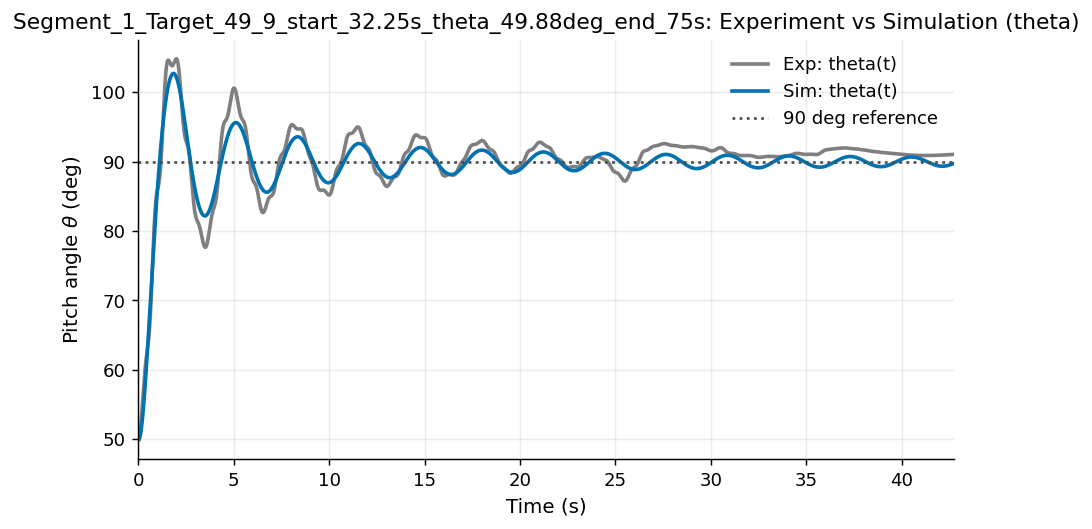

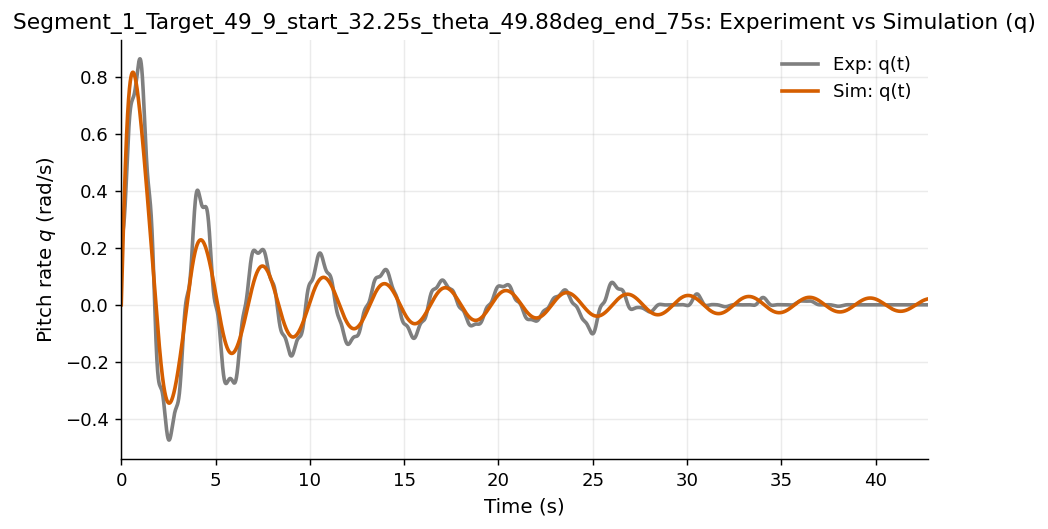

In [21]:
# --- Align and plot: theta(t) and q(t) (if q available in experiment) ---

t_exp = seg_exp['t'].to_numpy(dtype=float)
theta_exp = seg_exp['theta_deg'].to_numpy(dtype=float)

fig, ax = plt.subplots()
ax.plot(t_exp, theta_exp, color=PAL['gray'], linestyle='-', label='Exp: theta(t)')
ax.plot(df_sim['t'], df_sim['theta_deg'], color=PAL['blue'], label='Sim: theta(t)')
ax.axhline(90.0, color='0.3', linestyle=':', linewidth=1.5, label='90 deg reference')
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'Pitch angle $\theta$ (deg)')
_finalize_ax(ax, title=f'{SEG_LABEL}: Experiment vs Simulation (theta)')
ax.legend(frameon=False, loc='best')
fig.tight_layout()

if 'q_rad_s' in seg_exp.columns:
    fig, ax = plt.subplots()
    ax.plot(t_exp, seg_exp['q_rad_s'], color=PAL['gray'], linestyle='-', label='Exp: q(t)')
    ax.plot(df_sim['t'], df_sim['q'], color=PAL['vermillion'], label='Sim: q(t)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(r'Pitch rate $q$ (rad/s)')
    _finalize_ax(ax, title=f'{SEG_LABEL}: Experiment vs Simulation (q)')
    ax.legend(frameon=False, loc='best')
    fig.tight_layout()
else:
    print('Experimental segment has no q column; only theta(t) is plotted.')


## 下一步建议（验证逻辑更严谨）
- **Out-of-sample**：用 Segment 2/Segment 3 的不同初始角度段做验证，避免“同段辨识同段验证”的自洽拟合。
- **单位/零点核对**：如果你的实验 θ 定义不是 `Theta_Phys_deg = 90 + PCA(angleX,angleY)`，请把载入部分改成与你实际一致的转换。
- **输入一致性**：如果实验中存在缆绳、阻尼随速度变化等，请确认 `configs/params_nominal.yaml` 与本次实验条件一致。